# **Kaggle Project final: Evaluating Student Writing**

### **The mission we are dealing with:**

On this competition we will identify elements in student writing.
More specifically, we will automatically segment texts and classify argumentative and rhetorical elements in essays written by 6th-12th grade students.

In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import torch
from IPython.core.display import display, HTML
from transformers import *
from transformers import AutoModelForMaskedLM, AutoTokenizer, AutoConfig, TFAutoModel ,DataCollatorForLanguageModeling
import warnings
from tqdm import tqdm
import plotly.graph_objects as go
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
print('TF version',tf.__version__)

TF version 2.6.2


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## **presenting the data**

In [3]:
train = pd.read_csv('../input/feedback-prize-2021/train.csv')
train.head()

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...


In [4]:
raw_text_files = os.listdir('../input/feedback-prize-2021/train')
print(f'Training data consists of {len(raw_text_files)} texts')
print(f'Training data consists of {train.shape[0]} annotaions')
print(f'Each essay contains average {round(train.shape[0]/len(raw_text_files), 1)} annotaions.')

Training data consists of 15594 texts
Training data consists of 144293 annotaions
Each essay contains average 9.3 annotaions.


Paint the discourse type with different colors.

here is the code that enotate the essay to category and give color to each one.

In [5]:
# iterate each discourse type and print it in the color as we wished
def color_article(id):
    sample = train.loc[train['id'] == id] # for any id we will get table of 9 rows and 8 column (8 is the annotated version of all essay)
    for i in range(sample.shape[0]): 
        text = sample['discourse_text'].iloc[i]
        discourse = sample['discourse_type'].iloc[i]
        if discourse == 'Lead': # here we choose which part to color.
            color = '(255, 102, 204)'    # (red, grin, blue) the number is dosnt metter thaere is table of color in google
        elif discourse == 'Position':
            color = '(255, 0, 0)'
        elif discourse == 'Claim':
            color = '(0, 238, 0)'
        elif discourse == 'Counterclaim':
            color = '(0,0,0)'
        elif discourse == 'Rebuttal':
            color = '(0,0,255)'
        elif discourse == 'Evidence':
            color = '(139,69,0)'
        elif discourse == 'Concluding Statement':
            color = '(61,145,64)'
        sample_html_text = '<p style="color:rgb' + str(color) + ';">' + str(text) +'  ---> ' +str(discourse) + '</p>'
        display(HTML(sample_html_text))

Before the enotation and saperate to colors

In [6]:
with open('../input/feedback-prize-2021/train/007ACE74B050.txt') as f:
    contents = f.read()
    print(contents)

Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform

I think that the face is a natural landform because there is no life on Mars that we have descovered yet. If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, "It's not easy to target Cydonia," in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform.

Peo

After the color mark enotation.

In [7]:
color_article("007ACE74B050") # here we can see example.

In [8]:
# count number of elements per discouse type in each essay (for example 1 lead 2 claim ....)
discourse_type_number = train.groupby(['id','discourse_type']).nunique().reset_index()[['id','discourse_type','discourse_id']]

# plot a box chart to show quantiles, mean and median of nr of elements per discourse type
fig = go.Figure()
discourse = train['discourse_type'].unique() #array(['Lead', 'Position', 'Evidence', 'Claim', 'Concluding Statement','Counterclaim', 'Rebuttal']

for d in discourse:
    dataset = discourse_type_number.loc[discourse_type_number['discourse_type'] == d]    
    fig.add_trace(go.Box(y=dataset['discourse_id'], 
                         text = dataset['id'],
                         hovertemplate='<b>id: %{text} - <br>Number of discourse elements - %{y:.1f}</b>',
                         name=d))
    
fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)
fig.update_layout(showlegend = False,
                  title = 'Amount of discouse per types in an essay <sup><br>',
                  yaxis_title="Number of discourse elements")
fig.show()

## **building the model**

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
# token_from_path = '../input/long-former-chanel-and-noam'
load_model_path = True
model_path = '../input/long-former-chanel-and-noam'  
longformer_model = 'allenai/longformer-base-4096'
strategy = tf.distribute.get_strategy()
print('single strategy')
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
print('Mixed precision enabled')

ids = train.id.unique()
max_words_text = 1024
tokenizer = AutoTokenizer.from_pretrained(model_path)
txt_tokens = np.zeros((len(ids),max_words_text), dtype='int32')
txt_attention = np.zeros((len(ids),max_words_text), dtype='int32')

single strategy
Mixed precision enabled


In [10]:
leadB = np.zeros((len(ids),max_words_text))
leadI = np.zeros((len(ids),max_words_text))
positionB = np.zeros((len(ids),max_words_text))
positionI = np.zeros((len(ids),max_words_text))
evidenceB = np.zeros((len(ids),max_words_text))
evidenceI = np.zeros((len(ids),max_words_text))
claimB = np.zeros((len(ids),max_words_text))
claimI = np.zeros((len(ids),max_words_text))
conclusionB = np.zeros((len(ids),max_words_text))
conclusionI = np.zeros((len(ids),max_words_text))
counterclaimB = np.zeros((len(ids),max_words_text))
counterclaimI = np.zeros((len(ids),max_words_text))
rebuttalB = np.zeros((len(ids),max_words_text))
rebuttalI = np.zeros((len(ids),max_words_text))

In [11]:
discourse_B = [leadB, positionB, evidenceB, claimB, conclusionB, counterclaimB, rebuttalB]
discourse_I = [leadI, positionI, evidenceI, claimI, conclusionI, counterclaimI, rebuttalI]
discourse_type_map = {'Lead':0, 'Position':1, 'Evidence':2, 'Claim':3, 'Concluding Statement':4,
             'Counterclaim':5, 'Rebuttal':6}

text_lens = []
for text_id in range(len(ids)):  
    txt_file = open(f'../input/feedback-prize-2021/train/{ids[text_id]}.txt', 'r').read()
    text_lens.append( len(txt_file.split()))
    tokens = tokenizer.encode_plus(txt_file, max_length=max_words_text, padding='max_length',#Pad to a maximum length specified with the argument max_length 
                                   truncation=True, return_offsets_mapping=True) #return (char_start, char_end) for each token.
    txt_tokens[text_id,] = tokens['input_ids']  # convert each word in text to number (token)
    txt_attention[text_id,] = tokens['attention_mask'] # tensor of zeros and ones - 1 represent token and 0 represent padding

    offsets = tokens['offset_mapping'] # list of taples. each represent the start and the end char of each word
    offset_idx = 0
    txt_data = train.loc[train.id==ids[text_id]]
    for i,row in txt_data.iterrows():
        dis_start = row.discourse_start
        dis_end = row.discourse_end
        if offset_idx>len(offsets)-1:
            break
        char_start = offsets[offset_idx][0]
        char_end = offsets[offset_idx][1]
        beginning = True
        while dis_end>char_start:
            if (char_start>=dis_start)&(dis_end>=char_end):
                k = discourse_type_map[row.discourse_type]
                if beginning:
                    discourse_B[k][text_id][offset_idx] = 1
                    beginning = False
                else:
                    discourse_I[k][text_id][offset_idx] = 1
            offset_idx += 1
            if offset_idx>len(offsets)-1:
                break
            char_start = offsets[offset_idx][0]
            char_end = offsets[offset_idx][1]

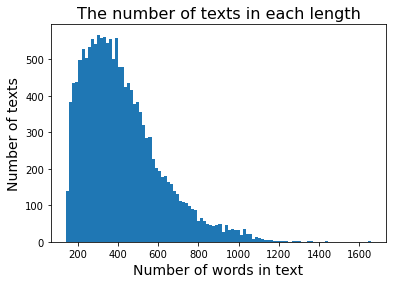

In [12]:
plt.hist(text_lens,bins=100)
plt.title('The number of texts in each length',size=16)
plt.xlabel('Number of words in text',size=14)
plt.ylabel('Number of texts',size=14)
plt.show()

From the histogram of train word counts above, we see that using a transformer width of 1024 is a good comprise of capturing most of the data's signal but not having too large a model. 

In [13]:
classified_texts = np.zeros((len(ids),max_words_text,15), dtype='int32')
dis_elements = 7
for element in range(dis_elements):
    classified_texts[:,:,2*element] = discourse_B[element]
    classified_texts[:,:,2*element+1] = discourse_I[element]
classified_texts[:,:,14] = 1-np.max(classified_texts,axis=-1)

Build Model

We will use LongFormer backbone and add our own NER head using one hidden layer of size 256 and one final layer with softmax. We use 15 classes because we have a B class and I class for each of 7 labels. And we have an additional class (called O class) for tokens that do not belong to one of the 14 classes.

In [14]:
def longformer_model():
    
    tokens = tf.keras.layers.Input(shape=(max_words_text,), name = 'tokens', dtype=tf.int32)
    attention = tf.keras.layers.Input(shape=(max_words_text,), name = 'attention', dtype=tf.int32)
    
    config = AutoConfig.from_pretrained(model_path+'/config.json') 
    backbone = TFAutoModel.from_pretrained(model_path+'/tf_model.h5', config=config)
    
    x = backbone(tokens, attention_mask=attention)
    x = tf.keras.layers.Dense(256, activation='relu')(x[0])
    x = tf.keras.layers.Dense(15, activation='softmax', dtype='float32')(x)
    
    model = tf.keras.Model(inputs=[tokens,attention], outputs=x)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
                  loss = [tf.keras.losses.CategoricalCrossentropy()],
                  metrics = [tf.keras.metrics.CategoricalAccuracy()])
    
    return model 

In [15]:
epochs = 5
batch_size = 4 
lrs = [0.25e-4, 0.25e-4, 0.25e-4, 0.25e-4, 0.25e-4] 
def epoch_for_learning_rate(e):
    return lrs[e]
learning_rate = tf.keras.callbacks.LearningRateScheduler(epoch_for_learning_rate, verbose = True)

with strategy.scope():
    model = longformer_model()

All model checkpoint layers were used when initializing TFLongformerModel.

All the layers of TFLongformerModel were initialized from the model checkpoint at ../input/long-former-chanel-and-noam/tf_model.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFLongformerModel for predictions without further training.


Train the model

In [16]:
np.random.seed(42)
train_data = np.random.choice(np.arange(len(ids)),int(0.9*len(ids)),replace=False)
valid_data = np.setdiff1d(np.arange(len(ids)),train_data)
np.random.seed(None)
print('Number of texts in train:',len(train_data),', Number of texts in validation:',len(valid_data))

Number of texts in train: 14034 , Number of texts in validation: 1560


In [17]:
if load_model_path:
    model.load_weights('../input/weight2/trained_model1.h5')
else:
    os.mkdir('weights')
    history = model.fit(x = [txt_tokens[train_data,], txt_attention[train_data,]],
              y = classified_texts[train_data,],
              validation_data = ([txt_tokens[valid_data,], txt_attention[valid_data,]],
                                 classified_texts[valid_data,]),
              callbacks = [learning_rate],
              epochs = epochs,
              batch_size = batch_size,
              verbose = 2)
    model.save_weights('weights/trained_model1.h5')

In [18]:
if load_model_path:
    pass
else:        
    # list all data in history
    print(history.history.keys())     
    print(history.history)  
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy']) 
    plt.plot(history.history['val_categorical_accuracy'])  
    plt.title('model accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [19]:
model_pred_valid = model.predict([txt_tokens[valid_data,], txt_attention[valid_data,]],  
                  batch_size=16, verbose=2)       #Generates output predictions for the input samples.
print('OOF predictions shape:',model_pred_valid.shape)
oof_preds = np.argmax(model_pred_valid,axis=-1)  

2022-03-15 16:32:06.650698: W tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2025] No (suitable) GPUs detected, skipping auto_mixed_precision_cuda graph optimizer
2022-03-15 16:32:08.318437: W tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2025] No (suitable) GPUs detected, skipping auto_mixed_precision_cuda graph optimizer


98/98 - 3446s
OOF predictions shape: (1560, 1024, 15)


In [20]:
discourse_type_map_inverse = {v:k for k,v in discourse_type_map.items()}
discourse_type_map_inverse[7] = 'blank'

def make_prediction(dataset='train', verbose=True, text_ids=ids[valid_data], preds=oof_preds):
    all_pred = []
    for text_id in range(len(preds)):
    
        txt_file = open(f'../input/feedback-prize-2021/{dataset}/{text_ids[text_id]}.txt', 'r').read()
        tokens = tokenizer.encode_plus(txt_file, max_length=max_words_text, padding='max_length',
                                   truncation=True, return_offsets_mapping=True)
        offest = tokens['offset_mapping']
    
        word_count = []
        blank = True
        for i in range(len(txt_file)):
            if (txt_file[i]!=' ')&(txt_file[i]!='\n')&(txt_file[i]!='\xa0')&(txt_file[i]!='\x85')&(blank==True):
                word_count.append(i) #insert the index of first char of every word
                blank=False
            elif (txt_file[i]==' ')|(txt_file[i]=='\n')|(txt_file[i]=='\xa0')|(txt_file[i]=='\x85'):
                blank=True
        word_count.append(1e6)
        word_map = -1 * np.ones(max_words_text,dtype='int32')
        word_count_index = 0
        for i in range(len(offest)):
            if offest[i][1]==0: continue # ignore padding
            while offest[i][0]>=word_count[word_count_index+1]: 
                word_count_index += 1
            word_map[i] = int(word_count_index)
        pred = preds[text_id,]/2.0
    
        index = 0
        while index<max_words_text:
            prediction = []
            start = pred[index]
            if start in list(range(0,8)):
                prediction.append(word_map[index])
                index += 1
                if index>=max_words_text: break
                while pred[index]==start+0.5:
                    if not word_map[index] in prediction:
                        prediction.append(word_map[index])
                    index += 1
                    if index>=max_words_text: break
            else:
                index += 1
            prediction = [x for x in prediction if x!=-1]
            if len(prediction)>4:
                all_pred.append( (text_ids[text_id], discourse_type_map_inverse[int(start)], 
                                ' '.join([str(x) for x in prediction]) ) )
                
    txt_data = pd.DataFrame(all_pred)
    txt_data.columns = ['id','class','predictionstring']
    
    return txt_data

In [21]:
my_preds = make_prediction( dataset='train', verbose=True, text_ids=ids[valid_data] )
my_preds.head()

,id,class,predictionstring
0,50B3435E475B,Lead,3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20...
1,50B3435E475B,Position,63 64 65 66 67 68 69 70 71 72 73 74 75
2,50B3435E475B,Claim,76 77 78 79 80 81 82 83 84 85 86 87
3,50B3435E475B,Evidence,88 89 90 91 92 93 94 95 96 97 98 99 100 101 10...
4,50B3435E475B,Claim,162 163 164 165 166 167 168 169 170 171 172 17...


In [22]:
# CODE FROM : Rob Mulla @robikscube
# https://www.kaggle.com/robikscube/student-writing-competition-twitch
def calc_overlap(row):
    """
    Calculates the overlap between prediction and
    ground truth and overlap percentages used for determining
    true positives.
    """
    set_pred = set(row.predictionstring_pred.split(' '))
    set_gt = set(row.predictionstring_gt.split(' '))
    # Length of each and intersection
    len_gt = len(set_gt)
    len_pred = len(set_pred)
    inter = len(set_gt.intersection(set_pred))
    overlap_1 = inter / len_gt
    overlap_2 = inter/ len_pred
    return [overlap_1, overlap_2]


def score_feedback_comp(pred_df, gt_df):
    """
    A function that scores for the kaggle
        Student Writing Competition
        
    Uses the steps in the evaluation page here:
        https://www.kaggle.com/c/feedback-prize-2021/overview/evaluation
    """
    gt_df = gt_df[['id','discourse_type','predictionstring']] \
        .reset_index(drop=True).copy()
    pred_df = pred_df[['id','class','predictionstring']] \
        .reset_index(drop=True).copy()
    pred_df['pred_id'] = pred_df.index
    gt_df['gt_id'] = gt_df.index
    # Step 1. all ground truths and predictions for a given class are compared.
    joined = pred_df.merge(gt_df,
                           left_on=['id','class'],
                           right_on=['id','discourse_type'],
                           how='outer',
                           suffixes=('_pred','_gt')
                          )
    joined['predictionstring_gt'] = joined['predictionstring_gt'].fillna(' ')
    joined['predictionstring_pred'] = joined['predictionstring_pred'].fillna(' ')

    joined['overlaps'] = joined.apply(calc_overlap, axis=1)

    # 2. If the overlap between the ground truth and prediction is >= 0.5, 
    # and the overlap between the prediction and the ground truth >= 0.5,
    # the prediction is a match and considered a true positive.
    # If multiple matches exist, the match with the highest pair of overlaps is taken.
    joined['overlap1'] = joined['overlaps'].apply(lambda x: eval(str(x))[0])
    joined['overlap2'] = joined['overlaps'].apply(lambda x: eval(str(x))[1])


    joined['potential_TP'] = (joined['overlap1'] >= 0.5) & (joined['overlap2'] >= 0.5)
    joined['max_overlap'] = joined[['overlap1','overlap2']].max(axis=1)
    tp_pred_ids = joined.query('potential_TP') \
        .sort_values('max_overlap', ascending=False) \
        .groupby(['id','predictionstring_gt']).first()['pred_id'].values

    # 3. Any unmatched ground truths are false negatives
    # and any unmatched predictions are false positives.
    fp_pred_ids = [p for p in joined['pred_id'].unique() if p not in tp_pred_ids]

    matched_gt_ids = joined.query('potential_TP')['gt_id'].unique()
    unmatched_gt_ids = [c for c in joined['gt_id'].unique() if c not in matched_gt_ids]

    # Get numbers of each type
    TP = len(tp_pred_ids)
    FP = len(fp_pred_ids)
    FN = len(unmatched_gt_ids)
    #calc microf1
    my_f1_score = TP / (TP + 0.5*(FP+FN))
    return my_f1_score

In [23]:
valid = train.loc[train['id'].isin(ids[valid_data])]

In [24]:
f1s = []
CLASSES = my_preds['class'].unique()
for c in CLASSES:
    pred_df = my_preds.loc[my_preds['class']==c].copy()
    gt_df = valid.loc[valid['discourse_type']==c].copy()
    f1 = score_feedback_comp(pred_df, gt_df)
    print(c,f1)
    f1s.append(f1)
print()
print('Overall',np.mean(f1s))

Lead 0.814042786615469
Position 0.673582295988935
Claim 0.6026842778014486
Evidence 0.6847481507573089
Concluding Statement 0.7957235586101565
Counterclaim 0.46105919003115264
Rebuttal 0.3746556473829201

Overall 0.6294994153124843


In [25]:
files = os.listdir('../input/feedback-prize-2021/test')
test_ids = [f.replace('.txt','') for f in files if 'txt' in f]

In [26]:
test_tokens = np.zeros((len(test_ids),max_words_text), dtype='int32')
test_attention = np.zeros((len(test_ids),max_words_text), dtype='int32')

for text_id in range(len(test_ids)):  
    txt_file = open(f'../input/feedback-prize-2021/test/{test_ids[text_id]}.txt', 'r').read()
    tokens = tokenizer.encode_plus(txt_file, max_length=max_words_text, padding='max_length',
                                   truncation=True, return_offsets_mapping=True)
    test_tokens[text_id,] = tokens['input_ids']
    test_attention[text_id,] = tokens['attention_mask']

In [27]:
model_pred_test = model.predict([test_tokens, test_attention], 
                  batch_size=16, verbose=2) 
print('Test predictions shape:',model_pred_test.shape)
test_preds = np.argmax(model_pred_test,axis=-1)

1/1 - 11s
Test predictions shape: (5, 1024, 15)


In [28]:
submission_file = make_prediction( dataset='test', verbose=False, text_ids=test_ids, preds=test_preds )
submission_file.head() 

,id,class,predictionstring
0,0FB0700DAF44,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
1,0FB0700DAF44,Position,41 42 43 44 45 46 47
2,0FB0700DAF44,Claim,49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
3,0FB0700DAF44,Claim,66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 8...
4,0FB0700DAF44,Position,108 109 110 111 112 113 114 115 116 117 118 119


In [29]:
# WRITE SUBMISSION CSV
submission_file.to_csv('submission.csv',index=False)